In [1]:
import os
import xarray as xr
import datetime
from datetime import timedelta
import pickle
import sys


# -----------
sys.path.append(os.path.abspath(".."))
from utils.inputs import *
from utils.outputs import *
from utils.simulations import *
from utils.custom_errors import *


import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(".."))

data_path = "data/"

/home/thom/Desktop/CIPM/FruitFlyPheno


In [3]:
import time


def fflies_model_2(data, start, threshold, generations=3):
    """
    Simulates a model to calculate the number of days required for a cumulative sum
    of data values to reach a specified threshold, starting from a given position.
    Parameters:
    -----------
    data : xarray.DataArray or numpy.ndarray
        The input data array containing numerical values. If a numpy array is provided,
        it will be converted to an xarray DataArray.
    start : int
        The starting index in the data array from which the calculation begins.
    threshold : float
        The target cumulative sum value to be reached. This value is scaled by the
        number of generations.
    generations : int, optional
        The scaling factor for the threshold. Default is 3.
    Returns:
    --------
    int
        The number of elapsed days required to reach or exceed the threshold cumulative sum.
    Raises:
    -------
    HistoricalDataBufferError
        If the cumulative sum does not reach the threshold within the data range,
        an error is raised suggesting increasing the historical data buffer.
    ValueError
        If the data contains NaN values at the specified indices, the function
        returns -1 to indicate invalid input.
    Notes:
    ------
    - The function assumes the input data is a one-dimensional array.
    - If the cumulative sum does not reach the threshold, a detailed error message
      is printed before raising the exception.
    """
    # Ensure data is an xarray DataArray
    if isinstance(data, np.ndarray):
        data = xr.DataArray(data)

    threshold = threshold * generations
    # threshold = threshold * generations
    # Initialize cumulative sum and elapsed days
    cumsum = 0
    elapsed_days = 0

    # Iterate through the data array starting from the given start position
    for i in range(start, len(data)):
        # Add the value of the current position to the cumsum
        if np.isnan(data[i]):
            return -1
        cumsum += data[i]
        # Increment the elapsed days
        elapsed_days += 1
        # If the cumsum is greater than or equal to the threshold, return the number of elapsed days
        if cumsum >= threshold:
            return elapsed_days

    # If the threshold is not reached, return the total number of days
    print("cumsum not reached" + str(cumsum) + str(elapsed_days))
    raise HistoricalDataBufferError(
        "Threshold not reached - you may be calculating for a cold area. \n Try increasing the historical data buffer by 100 days."
    )


def apply_fflies_model_run_distributed(data, date, dd_threshold=754, generations=3):
    # Apply the wrapper function over the x and y dimensions using multi-threading or dask
    result = xr.apply_ufunc(
        fflies_model_2,
        data,
        date,
        dd_threshold,
        generations,
        input_core_dims=[["t"], [], [], []],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[int],
    )
    result.name = "days_to_f3"
    result = result.where(result != -1, np.nan)
    return result


import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


def plot_xr_with_point_and_circle(data, point_coords, circle_radius_km=15, alpha=0.8):
    """
    Plots an xarray DataArray on a map with a point and a circle overlay.
    Parameters:
    -----------
    data : xarray.DataArray
        The data to be plotted. It should be geospatial data compatible with the PlateCarree projection.
    point_coords : tuple
        A tuple containing the latitude and longitude of the point to be plotted (lat, lon).
    circle_radius_km : float, optional
        The radius of the circle to be drawn around the point, in kilometers. Default is 15 km.
    alpha : float, optional
        The transparency level of the data overlay. Default is 0.8.
    Returns:
    --------
    None
        This function does not return any value. It displays the plot.
    Notes:
    ------
    - The function uses OpenStreetMap (OSM) as the basemap.
    - The circle radius is converted from kilometers to degrees using an approximate conversion factor.
    - The plot includes a colorbar labeled "Days to F3" and a title indicating the start date of the calculation.
    """

    # data is an xarray DataArray
    point_lon = point_coords[1]
    point_lat = point_coords[0]
    # Create a plot with a basemap
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # ax.set_extent(extent, crs=ccrs.PlateCarree())
    vmax = data.max()
    # Add an OSM basemap
    osm = cimgt.OSM()
    ax.add_image(osm, 10)
    # Plot the data
    data.plot(
        ax=ax,
        cmap="viridis",
        alpha=alpha,
        transform=ccrs.PlateCarree(),
        add_colorbar=True,
        vmin=-1,
        vmax=vmax,
        cbar_kwargs={"label": "Days to F3"},
    )

    # create date from day of year

    date = datetime.datetime(2001, 1, 1) + datetime.timedelta(240 - 1)
    # Plot the point
    ax.plot(point_lon, point_lat, "ro", markersize=10, transform=ccrs.PlateCarree())

    # Plot the circle
    circle_radius_deg = (
        circle_radius_km / 111.32
    )  # Convert radius from km to degrees (approximation)
    circle = Circle(
        (point_lon, point_lat),
        circle_radius_deg,
        color="red",
        fill=False,
        transform=ccrs.PlateCarree(),
    )
    ax.add_patch(circle)

    # Add labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Days to F3 Completion beginning on " + date.strftime("%Y-%m-%d"))

    # Show the plot
    plt.show()

In [5]:
def all_historical_model_run(
    coordinates,
    start_dates,
    fly_params,
    historical_data_buffer,
    cache_path=None,
    context_map=False,
    retry_count=0,
):
    coordinates_bbox = get_bounding_box(coordinates)

    first_date = min(start_dates)
    last_date = max(start_dates) + timedelta(
        days=historical_data_buffer
    )  # this will be removed when we switch to server - no need to call buffer
    if last_date > pd.Timestamp.now() - timedelta(days=2):
        raise PredictionNeededError("")
    n_days_data = (last_date - first_date).days
    first_date_str = first_date.strftime("%Y-%m-%d")

    if cache_path and os.path.exists(cache_path):
        with open(cache_path, "rb") as cache_file:
            raw_PRISM = pickle.load(cache_file)
    else:
        # Fetch historical data
        raw_PRISM = fetch_ncss_data(
            start_date=first_date_str, n_days=n_days_data, bbox=coordinates_bbox
        )

        # Save fetched data to cache
        if cache_path:
            with open(cache_path, "wb") as cache_file:
                pickle.dump(raw_PRISM, cache_file)

    DD_data = da_calculate_degree_days(fly_params["LTT"], fly_params["UTT"], raw_PRISM)
    del raw_PRISM
    gc.collect()

    check_data_at_point(DD_data, coordinates)

    ###############
    ## Run Model ##
    ###############
    try:
        # if we receive multiple points, we will just output the completion dates
        if len(coordinates) == 1 and context_map == True:
            time_index = np.argwhere(
                DD_data.t.values == np.datetime64(start_dates[0])
            ).flatten()[0]

            model_output = apply_fflies_model_run_distributed(
                DD_data, time_index, fly_params["dd_threshold"]
            )
            report_stats(model_output, coordinates)
            return plot_xr_with_point_and_circle(model_output, coordinates[0])
        else:
            for i, coord in enumerate(coordinates):
                time_index = np.argwhere(
                    DD_data.t.values == np.datetime64(start_dates[i])
                ).flatten()[0]
                print("time index", time_index)
                point_data = select_point_data(DD_data, coord)

                start_time = time.time()
                model_output_test = fflies_model_2(
                    point_data, time_index, fly_params["dd_threshold"]
                )
                print(model_output_test)
                end_time = time.time()
                print(f"fflies_model_1 execution time: {end_time - start_time} seconds")

                start_time = time.time()
                model_output = apply_fflies_model_run_distributed(
                    DD_data, time_index, fly_params["dd_threshold"]
                )
                end_time = time.time()
                print(
                    f"apply_fflies_model_run_distributed execution time: {end_time - start_time} seconds"
                )

                report_stats(model_output, coord)
            return None

    except HistoricalDataBufferError:
        if retry_count < 2:
            print(
                "insufficient accumulation of growing degree days over \n "
                + str(historical_data_buffer)
                + " days. Increasing buffer by 100 and retrying. \n"
                "You can try setting the historical_data_buffer to a higher value."
            )
            return all_historical_model_run(
                coordinates,
                start_dates,
                fly_params,
                historical_data_buffer + 100 * (retry_count + 1),
                cache_path,
                context_map,
                retry_count + 1,
            )
        else:
            print(
                "Historical Data Error encountered again. Exiting after two increases. Is this a very cold area?"
                " insufficient accumulation over"
                + str(historical_data_buffer + 300)
                + " days"
            )
            raise

In [6]:
def prediction_model_make_temp_data(
    DD_data, recent_weather_data, date_iteration_first_year, n, iteration_coords
):
    """
    Generate a temporary dataset by combining degree-day (DD) data and recent weather data.
    This function extracts a subset of the DD data starting from a specific date and location,
    and substitutes the first `n` days of the extracted data with the provided recent weather data.
    Args:
        DD_data (xarray.DataArray): The degree-day data array containing temperature-related information.
        recent_weather_data (numpy.ndarray or similar): The recent weather data to substitute into the DD data.
        date_iteration_first_year (datetime.datetime): The starting date of the iteration's first year.
        n (int): The number of years to offset from the starting date.
        iteration_coords (tuple): A tuple containing the latitude and longitude coordinates
                                  (latitude, longitude) for selecting the data.
    Returns:
        numpy.ndarray: A modified array where the first `n` days are replaced with recent weather data.
    """
    tmp_data = (
        DD_data.sel(
            t=slice(
                date_iteration_first_year + timedelta(days=n * 365),
                None,
            )
        )
        .sel(
            latitude=iteration_coords[0],
            longitude=iteration_coords[1],
            method="nearest",
        )
        .values
    )

    recent_weather_length = len(recent_weather_data)
    # substitute the first n days of tmp_data with the recent weather data
    tmp_data[:recent_weather_length] = recent_weather_data

    return tmp_data

In [7]:
def get_recent_weather_data(DD_data, date, iteration_coords):
    """Fetch recent weather data for the given date and coordinates."""
    return (
        DD_data.sel(t=slice(date, pd.Timestamp.now() - timedelta(days=2)))
        .sel(
            latitude=iteration_coords[0],
            longitude=iteration_coords[1],
            method="nearest",
        )
        .values
    )


def calculate_predicted_f3_days_linear(
    DD_data,
    recent_weather_data,
    date_iteration_first_year,
    prediction_years,
    iteration_coords,
    fly_params,
):
    """
    Calculate predicted F3 days for a given set of coordinates and weather data.

    This function predicts the F3 generation completion dates for fruit flies
    based on degree-day (DD) data, recent weather data, and specific parameters
    for a given number of prediction years.

    Args:
        DD_data (pd.DataFrame): Degree-day data used for predictions.
        recent_weather_data (pd.DataFrame): Recent weather data to supplement
            the degree-day calculations.
        date_iteration_first_year (datetime.date): The starting date for the
            first year's iteration.
        prediction_years (int): The number of years to predict F3 days for.
        iteration_coords (tuple): Coordinates (latitude, longitude) for the
            location of interest.
        fly_params (dict): Parameters for the fruit fly model, including:
            - "dd_threshold" (float): The degree-day threshold for F3 generation.

    Returns:
        list[datetime.date]: A list of predicted F3 generation completion dates
        for each year in the prediction range.
    """

    predicted_f3_days = []
    for n in range(prediction_years):
        tmp_data = prediction_model_make_temp_data(
            DD_data,
            recent_weather_data,
            date_iteration_first_year,
            n,
            iteration_coords,
        )

        finish_date = fflies_model_2(
            tmp_data,
            0,
            fly_params["dd_threshold"],
        )
        predicted_f3_days.append(finish_date)
    return predicted_f3_days


def process_start_dates():
    """Processes start dates to calculate predicted F3 days for fruit fly phenology.

    Args:
        DD_data (DataFrame): Degree-day data used for calculations.
        start_dates (list of datetime): List of start dates for processing.
        coordinates (list of tuples): List of coordinate pairs (latitude, longitude) corresponding to each start date.
        prediction_years (int): Number of years to consider for predictions.
        fly_params (dict): Parameters related to fruit fly development and behavior.

    Returns:
        list: A list of predicted F3 days for each start date and coordinate pair.
    DD_data, start_dates, coordinates, prediction_years, fly_params"
    """
    for i, date in enumerate(start_dates):
        month_day = date.strftime("%m-%d")
        date_iteration_first_year = date - timedelta(days=prediction_years * 365)
        iteration_coords = coordinates[i]

        # Fetch recent weather data
        recent_weather_data = get_recent_weather_data(DD_data, date, iteration_coords)

        # Calculate predicted F3 days
        predicted_f3_days = calculate_predicted_f3_days_linear(
            DD_data,
            recent_weather_data,
            date_iteration_first_year,
            prediction_years,
            iteration_coords,
            fly_params,
        )

In [12]:
def prediction_model_run(
    coordinates,
    start_dates,
    fly_params,
    n_days_data,
    cache_path,
    produce_plot=False,
    prediction_years=5,
):
    ######
    # Model Setup
    ######
    bbox = get_bounding_box(coordinates)
    first_date = min(start_dates)
    historical_data_first_year = first_date.year - prediction_years

    """
    replace to fetch data from server when available

    data = fetch_ncss_data(
        start_date=
        n_days=n_days_data,
        bbox=get_bounding_box(coordinates),
    )
    """
    if cache_path and os.path.exists(cache_path):
        with open(cache_path, "rb") as cache_file:
            raw_PRISM = pickle.load(cache_file)

    DD_data = da_calculate_degree_days(fly_params["LTT"], fly_params["UTT"], raw_PRISM)
    del raw_PRISM
    gc.collect()

    ##Model Run
    for i, date in enumerate(start_dates):
        date_iteration_first_year = date - timedelta(days=prediction_years * 365)
        iteration_coords = coordinates[i]
        recent_weather_data = get_recent_weather_data(DD_data, date, iteration_coords)
        predicted_f3_days = calculate_predicted_f3_days_linear(
            DD_data,
            recent_weather_data,
            date_iteration_first_year,
            prediction_years,
            iteration_coords,
            fly_params,
        )

    print("Predicted F3 days for ", iteration_coords, ":", predicted_f3_days)


run_plot_DD(
    [pd.to_datetime("2025-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=False,
)

Predicted F3 days for  (34.63115, -117.338321) : [237, 230, 230, 245, 231]


In [2]:
def run_plot_DD(
    start_dates,
    coordinates,
    target_species,
    historical_data_buffer=400,
    cache_path=os.path.join(data_path, "cache/pred_cache.pkl"),
    context_map=False,
    save_output=False,
    all_historical=None,
    force_prediction=False,
):
    """
    Generates a plot of completion dates for a given species at specified coordinates.

    Parameters:
    ----------
    start_dates : list of datetime
        List of start dates corresponding to each coordinate.
    coordinates : list of tuples (lat, lon)
        List of latitude and longitude pairs.
    target_species : str
        Name of the species to model.
    days_of_data : int
        Number of days of data to fetch - usually 180-200 is sufficient
    historical_data_buffer : int
        Number of days to buffer historical data for model run.
    cache_path : str
        Path to cache file for storing fetched data.
    context_map : bool
        If True, generates a context map for a single point.
    save_output : bool
        If True, saves the output data to a tiff file.
    Returns:
    -------
    matplotlib.figure.Figure
        A plot displaying degree-day completion for the given coordinates.

    Raises:
    ------
    ValueError:
        If the number of coordinates and dates do not match.
        If no coordinates are provided.
        If the start date is too early or the end date is in the future.
    """
    ###################
    ##Input Validation#
    ###################
    all_historical = validate_inputs(start_dates, coordinates, historical_data_buffer)

    # a bounding box if we have multiple points, a context map if we have a single point
    # loaded from .json file
    fly_params = load_species_params(target_species, data_path)

    # setup Modelvariables
    first_date = min(start_dates)
    last_date = max(start_dates) + timedelta(days=historical_data_buffer)
    n_days_data = (last_date - first_date).days

    ##########
    ##Model##
    ##########
    if all_historical:
        try:
            return all_historical_model_run(
                coordinates,
                start_dates,
                fly_params,
                n_days_data,
                cache_path,
                context_map,
            )
        except PredictionNeededError:
            all_historical = False
    if force_prediction or not all_historical:
        prediction_model_run(
            coordinates,
            start_dates,
            fly_params,
            n_days_data,
            cache_path,
            produce_plot=False,
        )
        # predict

In [3]:
run_plot_DD(
    [pd.to_datetime("2025-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=False,
    cache_path=os.path.join(data_path, "cache/pred_cache.pkl")
)

UnboundLocalError: cannot access local variable 'raw_PRISM' where it is not associated with a value

232  days to F3 completion at  (34.63115, -117.338321)


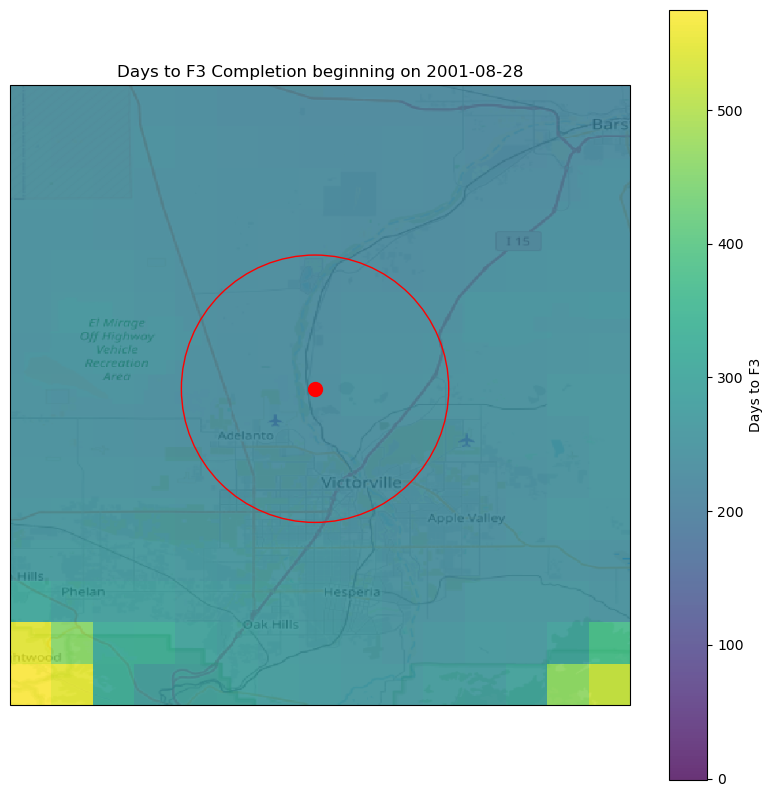

In [4]:
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=True,
    cache_path=os.path.join(data_path, "cache/cache.pkl"),
)

In [2]:
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
)

NameError: name 'run_plot_DD' is not defined

run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=False,
)
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",
    context_map=True,
)
### Why is map not plotting?

In [8]:
# test statements
"""
run_plot_DD(
    [pd.to_datetime("2002-01-01")],
    [(34.63115, -117.338321)],
    "Mexfly",


run_plot_DD(
    [pd.to_datetime("2002-01-01"), pd.to_datetime("2002-05-01")],
    [(34.63115, -117.338321), (34.68115, -117.336321)],
    "Mexfly",
)
"""

'\nrun_plot_DD(\n    [pd.to_datetime("2002-01-01")],\n    [(34.63115, -117.338321)],\n    "Mexfly",\n\n\nrun_plot_DD(\n    [pd.to_datetime("2002-01-01"), pd.to_datetime("2002-05-01")],\n    [(34.63115, -117.338321), (34.68115, -117.336321)],\n    "Mexfly",\n)\n'

In [2]:
import os
from datetime import datetime


# Parameters
start_date = "2020-01-01"
bbox = (-117.63832099999999, -117.038321, 34.33115, 34.931149999999995)
cache_path = "cache/pred_cache.pkl"

# Ensure the cache directory exists
os.makedirs(os.path.dirname(cache_path), exist_ok=True)

# Fetch the data
ncss_data = fetch_ncss_data(start_date=start_date, bbox=bbox)

# Save the data to the cache
with open(cache_path, "wb") as cache_file:
    pickle.dump(ncss_data, cache_file)

print(f"NCSS data saved to {cache_path}")

NCSS data saved to cache/pred_cache.pkl
